In [28]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import Forecast as fc
import pickle

In [29]:
# loading data

provinces = pd.read_csv('..\data\dati-province\dpc-covid19-ita-province.csv')
today = '2021-06-26T17:00:00'
today_data = provinces.loc[provinces['data']==today]

population = pd.read_csv('..\data\Popolazione_province.csv', index_col=0)

p_list = pd.read_csv('..\data\Provinces_list.csv')['Sigla'].tolist()

# Load the coordinates from the file
with open('..\data\coordinates_dict.pickle', 'rb') as file:
    coord_df = pickle.load(file)

# Load the distances from the file
with open('..\data\distances_df.pickle', 'rb') as file:
    distances_df = pickle.load(file)


In [30]:
# Load the dictionary from the file
with open('..\data\provinces_fit.pickle', 'rb') as file:
    provinces_fitted = pickle.load(file)

selected_start=200
wave_index = [[i for i, t in enumerate(provinces_fitted[sigla].L_starts) if t>selected_start][0] for sigla in p_list]
wave_params = [ provinces_fitted[sigla].L_waves[wave_index[i]].params  for i, sigla in enumerate(p_list)]
z1 = [np.log(param['K'].value) for param in wave_params]
z2 = [np.log(param['b'].value) for param in wave_params]
z3 = [np.log(param['c'].value) for param in wave_params]


In [31]:
# Distance matrix

D = distances_df.to_numpy()

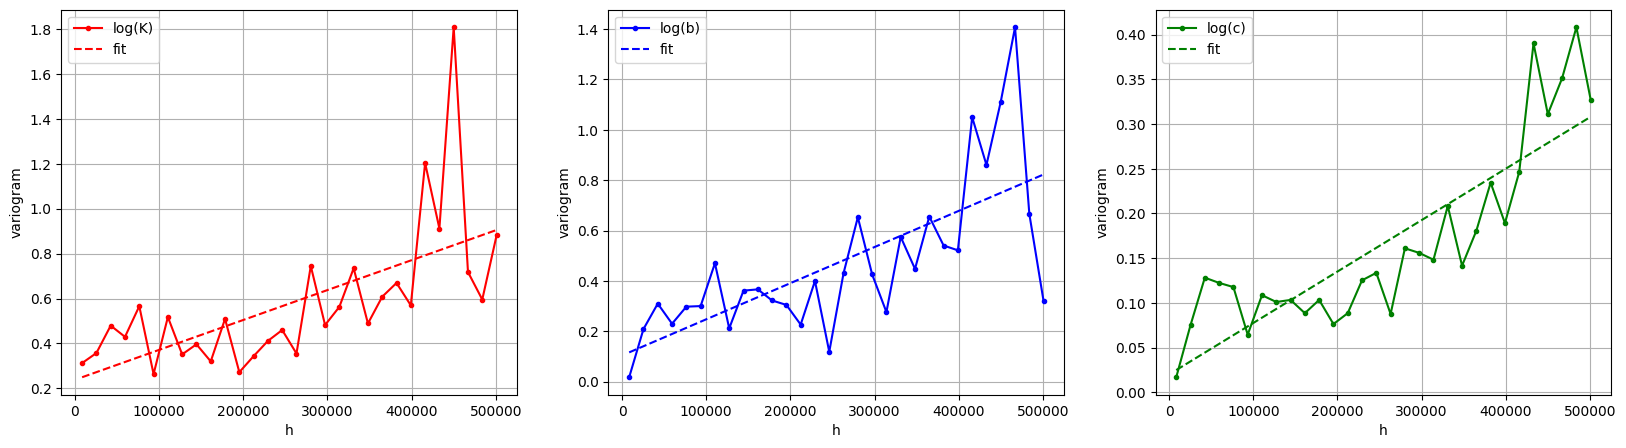

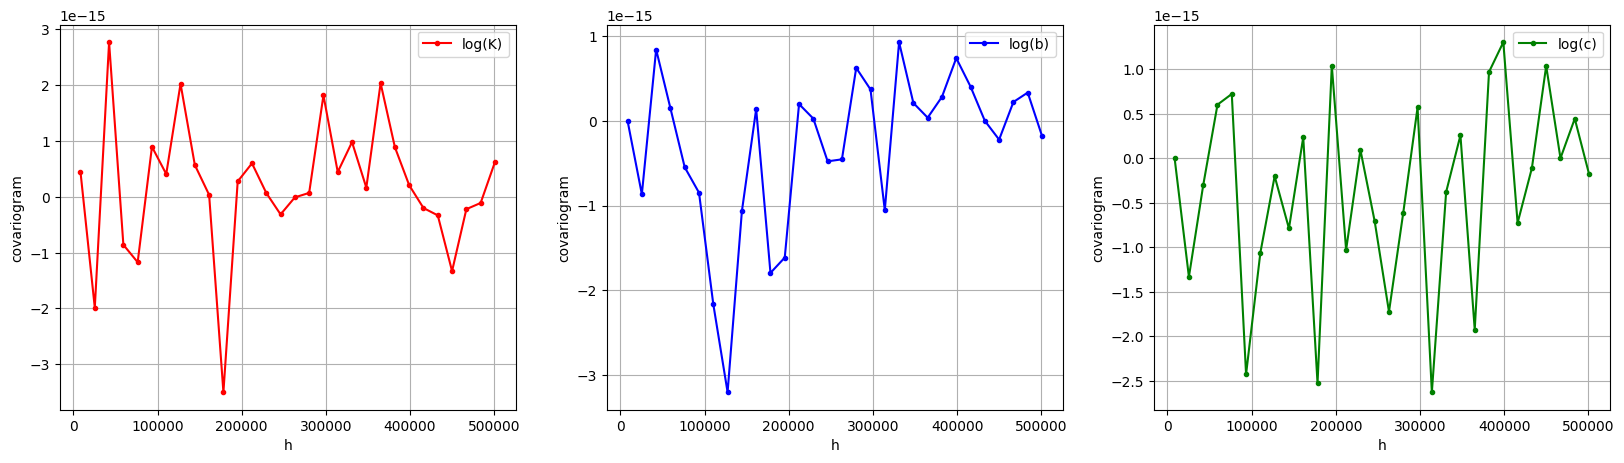

In [33]:
# Distance bins and empirical variograms and covariograms

D_max = np.amax(D)
n_points = D.shape[0]
n_bins = 30
bin_edges = np.linspace(0,D_max,n_bins+1)
bin_width = bin_edges[1]-bin_edges[0]
bin_centers = np.linspace(bin_width/2,D_max-bin_width/2, n_bins)
bins = []
for k in range(n_bins):
    bin_k = []
    for i in range(n_points):
        for j in range(i+1, n_points):
            if D[i,j]>bin_edges[k] and D[i,j]<=bin_edges[k+1]:
                bin_k.append((i,j))
    bins.append(bin_k)
            
gamma_K = np.zeros(n_bins)  # empirical variograms
gamma_b = np.zeros(n_bins)  # empirical variograms
gamma_c = np.zeros(n_bins)  # empirical variograms
C_K = np.zeros(n_bins)  # empirical covariograms
C_b = np.zeros(n_bins)  # empirical covariograms
C_c = np.zeros(n_bins)  # empirical covariograms
m_K = np.zeros(n_bins)  # empirical covariograms
m_b = np.zeros(n_bins)  # empirical covariograms
m_c = np.zeros(n_bins)  # empirical covariograms

for h in range(n_bins):     # Computation of gamma and m
    sum_K = 0
    sum_b = 0
    sum_c = 0
    var_K = 0
    var_b = 0
    var_c = 0
    for s in range(len(bins[h])):
        i = bins[h][s][0]
        j = bins[h][s][1]
        var_K += (z1[i]-z1[j])**2
        var_b += (z2[i]-z2[j])**2
        var_c += (z3[i]-z3[j])**2
        sum_K += z1[i]+z1[j]
        sum_b += z2[i]+z2[j]
        sum_c += z3[i]+z3[j]
    gamma_K[h]=1/(2*len(bins[h]))*var_K
    gamma_b[h]=1/(2*len(bins[h]))*var_b
    gamma_c[h]=1/(2*len(bins[h]))*var_c
    m_K[h]=1/(2*len(bins[h]))*sum_K
    m_b[h]=1/(2*len(bins[h]))*sum_b
    m_c[h]=1/(2*len(bins[h]))*sum_c

for h in range(n_bins):     # Computation of C
    sum_K = 0
    sum_b = 0
    sum_c = 0
    for s in range(len(bins[h])):
        i = bins[h][s][0]
        j = bins[h][s][1]
        sum_K += (z1[i]-m_K[h])+(z1[j]-m_K[h])
        sum_b += (z2[i]-m_b[h])+(z2[j]-m_b[h])
        sum_c += (z3[i]-m_c[h])+(z3[j]-m_c[h])
    C_K[h]=1/(len(bins[h]))*sum_K
    C_b[h]=1/(len(bins[h]))*sum_b
    C_c[h]=1/(len(bins[h]))*sum_c

# Fitting variograms
coefficients_K = np.polyfit(bin_centers, gamma_K, 1)
gamma_K_fit = np.polyval(coefficients_K, bin_centers)
coefficients_b = np.polyfit(bin_centers, gamma_b, 1)
gamma_b_fit = np.polyval(coefficients_b, bin_centers)
coefficients_c = np.polyfit(bin_centers, gamma_c, 1)
gamma_c_fit = np.polyval(coefficients_c, bin_centers)

plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.plot(bin_centers, gamma_K, color='red', marker='.', label='log(K)')
plt.plot(bin_centers, gamma_K_fit, color='red', linestyle='--', label='fit')
plt.xlabel('h')
plt.ylabel('variogram')
plt.grid(True)
plt.legend()
plt.subplot(1,3,2)
plt.plot(bin_centers, gamma_b, color='blue', marker='.', label='log(b)')
plt.plot(bin_centers, gamma_b_fit, color='blue', linestyle='--', label='fit')
plt.xlabel('h')
plt.ylabel('variogram')
plt.grid(True)
plt.legend()
plt.subplot(1,3,3)
plt.plot(bin_centers, gamma_c, color='green', marker='.', label='log(c)')
plt.plot(bin_centers, gamma_c_fit, color='green', linestyle='--', label='fit')
plt.xlabel('h')
plt.ylabel('variogram')
plt.grid(True)
plt.legend()

plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.plot(bin_centers, C_K, color='red', marker='.', label='log(K)')
plt.xlabel('h')
plt.ylabel('covariogram')
plt.grid(True)
plt.legend()
plt.subplot(1,3,2)
plt.plot(bin_centers, C_b, color='blue', marker='.', label='log(b)')
plt.xlabel('h')
plt.ylabel('covariogram')
plt.grid(True)
plt.legend()
plt.subplot(1,3,3)
plt.plot(bin_centers, C_c, color='green', marker='.', label='log(c)')
plt.xlabel('h')
plt.ylabel('covariogram')
plt.grid(True)
plt.legend()